In [32]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as snsDeath_Popu
from tabulate import tabulate
from datetime import datetime
import locale
import warnings

warnings.filterwarnings("ignore", category=UserWarning,
                        message="Boolean Series key will be reindexed to match DataFrame index")
from statsmodels.stats.proportion import proportions_ztest
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV


This project will demonstrate 

In [33]:
# import dataset

OriData = pd.read_csv('documents/python/Weekly_Counts_of_Deaths_by_State_and_Select_Causes__2014-2019.csv')

# Know your data

print(OriData.head(5))

# Drop columns those are not useful in the analysis
WorkData = OriData.drop(columns=['flag_allcause', 'flag_natcause',
                                 'flag_sept', 'flag_neopl', 'flag_diab', 'flag_alz', 'flag_inflpn',
                                 'flag_clrd', 'flag_otherresp', 'flag_nephr', 'flag_otherunk', 'flag_hd',
                                 'flag_stroke'])

# verify drop column
print(WorkData.head(5), end='\n\n')

print(f'There are total {len(WorkData)} observations for {len(WorkData.columns)} variables.')


  Jurisdiction of Occurrence  MMWR Year  MMWR Week Week Ending Date  \
0                    Florida       2014         43       10/25/2014   
1                    Florida       2014         44       11/01/2014   
2                    Florida       2014         45       11/08/2014   
3                    Florida       2014         46       11/15/2014   
4                    Florida       2014         47       11/22/2014   

   All  Cause  Natural Cause  Septicemia (A40-A41)  \
0        3381           3149                  38.0   
1        3501           3261                  43.0   
2        3646           3369                  44.0   
3        3615           3346                  43.0   
4        3672           3383                  39.0   

   Malignant neoplasms (C00-C97)  Diabetes mellitus (E10-E14)  \
0                          854.0                         81.0   
1                          859.0                         85.0   
2                          838.0                     

In [34]:
# EDA-1

# How many years' data
yearsdata = WorkData['MMWR Year'].unique()
print(tabulate([yearsdata], tablefmt='fancy_grid', showindex='never'), end='\n\n')

# How many unique years by states

N_states = WorkData['Jurisdiction of Occurrence'].nunique()

print(f'There are total {N_states} states.', end='\n\n')

print(WorkData.groupby('Jurisdiction of Occurrence')['MMWR Year'].nunique(), end='\n\n')

# We have all the 50 states, Washington D.C., and the USA deaths as well
# How many Null values

Tot_null = WorkData.isna().sum().reset_index()
NA_tbl = tabulate(Tot_null, headers=['column name', 'NA values'], showindex=False, tablefmt='fancy_grid')
print(NA_tbl)



╒══════╤══════╤══════╤══════╤══════╤══════╕
│ 2014 │ 2015 │ 2016 │ 2017 │ 2018 │ 2019 │
╘══════╧══════╧══════╧══════╧══════╧══════╛

There are total 54 states.

Jurisdiction of Occurrence
Alabama                 6
Alaska                  6
Arizona                 6
Arkansas                6
California              6
Colorado                6
Connecticut             6
Delaware                6
District of Columbia    6
Florida                 6
Georgia                 6
Hawaii                  6
Idaho                   6
Illinois                6
Indiana                 6
Iowa                    6
Kansas                  6
Kentucky                6
Louisiana               6
Maine                   6
Maryland                6
Massachusetts           6
Michigan                6
Minnesota               6
Mississippi             6
Missouri                6
Montana                 6
Nebraska                6
Nevada                  6
New Hampshire           6
New Jersey              6
New Me

In [35]:
# ETL-1

# Filter data for New York City and New York State
nyc_data = WorkData[WorkData['Jurisdiction of Occurrence'] == 'New York City']
nys_data = WorkData[WorkData['Jurisdiction of Occurrence'] == 'New York']

# Select the columns containing deaths by different causes
cause_columns = WorkData.iloc[:, 4:17]

# Sum the columns to get the total deaths by cause for each
nyc_total_deaths = nyc_data[cause_columns.columns].sum()
nys_total_deaths = nys_data[cause_columns.columns].sum()

print("Total Deaths by Cause for New York City:")
print(nyc_total_deaths)

print("\nTotal Deaths by Cause for New York State:")
print(nys_total_deaths)

print('\nTotal Deaths in NYC:')
print(nyc_total_deaths.sum())

print('\nTotal Deaths in NY State:')
print(nys_total_deaths.sum())

# Replace New York City and New York as New York
WorkData['Jurisdiction of Occurrence'] = WorkData['Jurisdiction of Occurrence'].replace(['New York City', 'New York'],
                                                                                        'New York')

# Select only the columns you want to sum (excluding non-death-related columns)
cause_columns = WorkData.iloc[:, 4:17]

# Create a dictionary to specify the aggregation function for each column
agg_dict = {}
for column in cause_columns.columns:
    agg_dict[column] = 'sum'

# Aggregate data for "New York" by grouping and summing other variables
WorkData = WorkData.groupby(['Jurisdiction of Occurrence', 'MMWR Year', 'MMWR Week']).agg(agg_dict).reset_index()

# Verify the calculation
updated_NYS = WorkData[WorkData['Jurisdiction of Occurrence'] == 'New York']

# Sum of deaths
deaths_NYS = updated_NYS[cause_columns.columns].sum()

# Total deaths
print('\nTotal Deaths in NYS:')
print(deaths_NYS.sum())



Total Deaths by Cause for New York City:
All  Cause                                                                                           323556.0
Natural Cause                                                                                        304196.0
Septicemia (A40-A41)                                                                                   1342.0
Malignant neoplasms (C00-C97)                                                                         78675.0
Diabetes mellitus (E10-E14)                                                                           11121.0
Alzheimer disease (G30)                                                                                6322.0
Influenza and pneumonia (J10-J18)                                                                     12030.0
Chronic lower respiratory diseases (J40-J47)                                                          10580.0
Other diseases of respiratory system (J00-J06,J30-J39,J67,J70-J98)             

In [36]:
#ETL-2

#Sort the dataset by State, year, and Week

WorkData = WorkData.sort_values(by=['Jurisdiction of Occurrence', 'MMWR Year', 'MMWR Week'], ascending=True)

# Combine Weekly deaths into a Yearly deaths column

# Select only the columns you want to sum (excluding non-death-related columns)
cause_columns = WorkData.iloc[:, 3:17]

# Create a new column 'Yearly Deaths' by summing deaths for each year
WorkData['Weekly Total Deaths'] = cause_columns.sum(axis=1)

# Now, 'Weekly Total Deaths' column will contain the sum of deaths for each year

print(tabulate(WorkData[['Jurisdiction of Occurrence', 'MMWR Year', 'MMWR Week','Weekly Total Deaths']].head(6), showindex=False, headers=['Jurisdiction of Occurrence', 'MMWR Year', 'MMWR Week','Weekly Total Deaths']), end='\n\n')


#Yearly deaths by States

YearlyDeaths = WorkData.groupby(['Jurisdiction of Occurrence', 'MMWR Year']).agg({'Weekly Total Deaths': 'sum'}).reset_index()
YearlyDeaths.rename({'Weekly Total Deaths':'Total Deaths'}, axis=1, inplace=True)
print(YearlyDeaths.shape, end='\n\n')
print(tabulate(YearlyDeaths.head(6), headers=YearlyDeaths.columns, showindex=False, tablefmt='fancy_grid'))




Jurisdiction of Occurrence      MMWR Year    MMWR Week    Weekly Total Deaths
----------------------------  -----------  -----------  ---------------------
Alabama                              2014            1                   2820
Alabama                              2014            2                   2865
Alabama                              2014            3                   2795
Alabama                              2014            4                   2758
Alabama                              2014            5                   2748
Alabama                              2014            6                   2608

(318, 3)

╒══════════════════════════════╤═════════════╤════════════════╕
│ Jurisdiction of Occurrence   │   MMWR Year │   Total Deaths │
╞══════════════════════════════╪═════════════╪════════════════╡
│ Alabama                      │        2014 │         133505 │
├──────────────────────────────┼─────────────┼────────────────┤
│ Alabama                      │        2015 

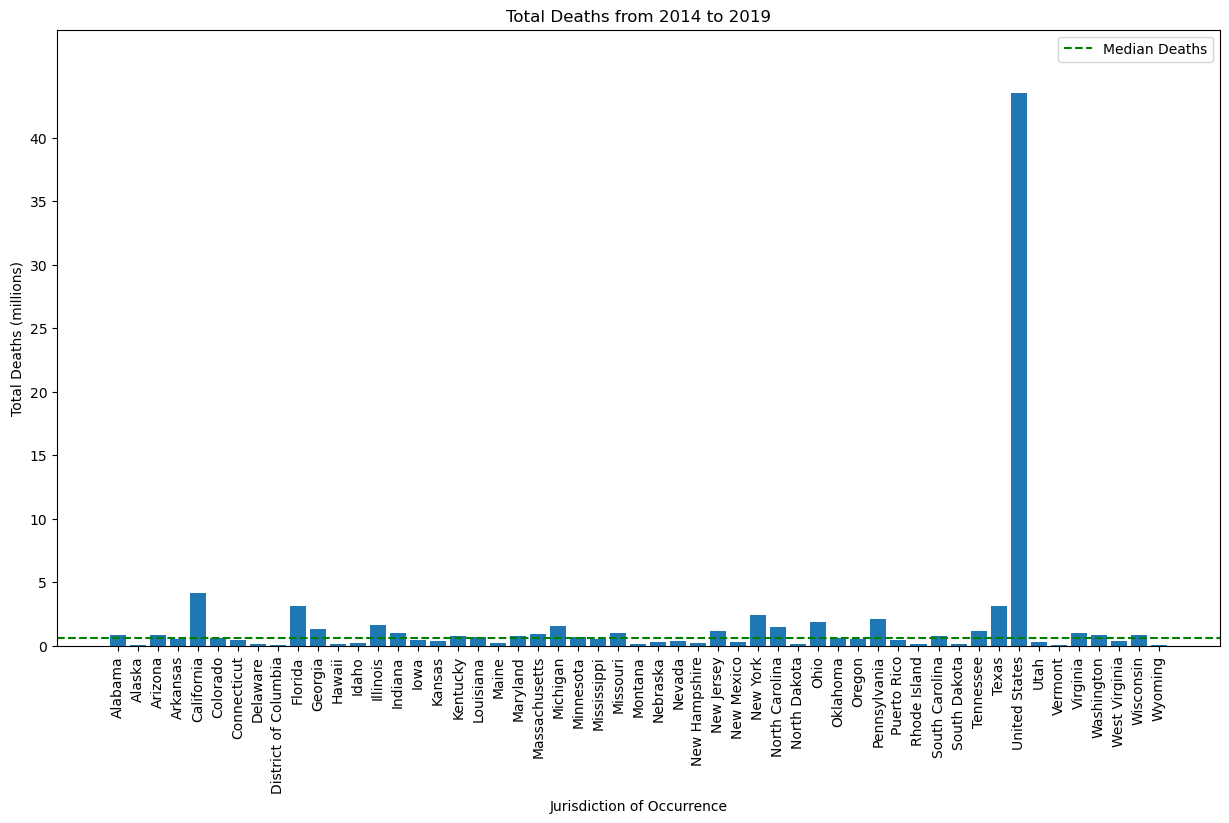

In [37]:
# EDA

# Yearly Deaths barplot by States

# Adjust the figure size as needed
plt.figure(figsize=(15, 8))

# Remove non-integer values from Total Deaths
YearlyDeaths_clean = YearlyDeaths.dropna()

#Calculating Total Deaths from year 2014 to 2019
Final_Death_cal = YearlyDeaths_clean.groupby('Jurisdiction of Occurrence')['Total Deaths'].sum().to_frame(name='Grand Total of Deaths').reset_index()
#print(Final_Death_cal.head(5))
#print(Final_Death_cal[Final_Death_cal['Jurisdiction of Occurrence']=='United States'])


# Plotting barplot
plt.bar(Final_Death_cal['Jurisdiction of Occurrence'], Final_Death_cal['Grand Total of Deaths'] / 10**6)

# Set labels and title
plt.xlabel('Jurisdiction of Occurrence')
plt.ylabel('Total Deaths (millions)')
plt.title('Total Deaths from 2014 to 2019')

# Adding deaths median line
plt.axhline(Final_Death_cal['Grand Total of Deaths'].median() / 10**6, color='Green', linestyle='--', label='Median Deaths')

# Add legend
plt.legend()

# Set X labels 90 degrees for better visibility
plt.xticks(rotation=90)

# Limiting Y values
plt.ylim(0, max(Final_Death_cal['Grand Total of Deaths'] / 10**6) + 5)

# Setting Y ticks
plt.yticks(range(0, int(max(Final_Death_cal['Grand Total of Deaths'] / 10**6)) + 1, 5))

plt.show()


In [38]:
# ETL-3
# How many deaths per 100,000 in the respective states

# Read population dataset
State_popu = pd.read_excel('/users/nikhildeshpande/documents/python/nst-est2019-01.xlsx')
print('\nColumns of State population dataframe:')
print(State_popu.columns)
print('\nHead of the Dataframe')
print(State_popu.head(5))

# Delete Estimate base column as it's not useful in the analysis
State_popu = State_popu.drop(columns=['Census', 'Estimates Base', 2010, 2011, 2012, 2013])

print('\nUpdated State Population dataframe:')
print(State_popu.head(5), end='\n\n')


# Reshaping Dataset to merge with Population Dataset
YearlyDeaths = YearlyDeaths.pivot_table(values='Total Deaths', index='Jurisdiction of Occurrence', columns='MMWR Year')
print('Reshaping YearlyDeaths to merge with Population Dataset\n')
print(YearlyDeaths.head(5), end='\n\n')

YearlyDeaths.to_csv("/users/nikhildeshpande/documents/python/Population_deaths.csv")

# Merge and verify the dataset

Death_Popu = YearlyDeaths.merge(State_popu,
                                left_on="Jurisdiction of Occurrence",
                                right_on="Demographics", how='inner',
                                suffixes=('_Deaths', '_Population'))

# Add a new column deaths per 100000 to calculate deaths per 100000

# Calculate deaths per 100000 for each year
for year in range(2014, 2020):
    Death_Popu[f'{year}_Deaths_per_100000'] = round((Death_Popu[f'{year}_Deaths'] / Death_Popu[f'{year}_Population'])
                                                    * 100000)

print('Deaths per 100,000\n')
print(Death_Popu.head(5), end='\n\n')
    
    
Death_Popu.to_csv("/users/nikhildeshpande/documents/python/death_pop.csv")




Columns of State population dataframe:
Index([  'Demographics',         'Census', 'Estimates Base',             2010,
                   2011,             2012,             2013,             2014,
                   2015,             2016,             2017,             2018,
                   2019],
      dtype='object')

Head of the Dataframe
    Demographics     Census  Estimates Base       2010       2011       2012  \
0  United States  308745538       308758105  309321666  311556874  313830990   
1        Alabama    4779736         4780125    4785437    4799069    4815588   
2         Alaska     710231          710249     713910     722128     730443   
3        Arizona    6392017         6392288    6407172    6472643    6554978   
4       Arkansas    2915918         2916031    2921964    2940667    2952164   

        2013       2014       2015       2016       2017       2018       2019  
0  315993715  318301008  320635163  322941311  324985539  326687501  328239523  
1    4830

    2014_Deaths  2015_Deaths  2016_Deaths  2017_Deaths  2018_Deaths  \
50      56514.0      56534.0      55516.0      56710.0      58048.0   
43     182920.0     183983.0     186001.0     191475.0     194370.0   
0      133505.0     134844.0     135456.0     138118.0     141210.0   
38     349574.0     351290.0     350181.0     355452.0     354352.0   
3       80560.0      81461.0      81137.0      83381.0      83481.0   
17     119509.0     120558.0     123616.0     124460.0     125730.0   
25     162116.0     162349.0     161316.0     167474.0     170369.0   
24      79769.0      81557.0      81877.0      83082.0      83475.0   
35     308098.0     309615.0     310839.0     321270.0     326007.0   
19      33995.0      35891.0      35131.0      36066.0      36227.0   

    2019_Deaths   Demographics  2014_Population  2015_Population  \
50      57851.0  West Virginia          1849489          1842050   
43     195395.0      Tennessee          6541223          6591170   
0      140329.

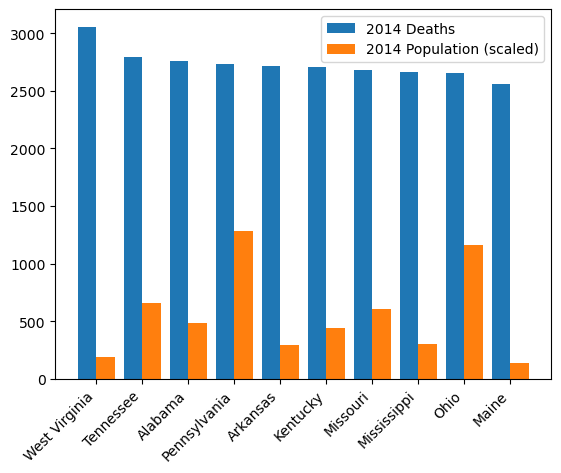

In [39]:

# States with the highest mortality rate

columns_to_sort_by = ['2014_Deaths_per_100000', '2015_Deaths_per_100000',
                   '2016_Deaths_per_100000', '2017_Deaths_per_100000',
                   '2018_Deaths_per_100000', '2019_Deaths_per_100000']

# Sort the dataset by the highest deaths per 100,000
Highest_deaths = Death_Popu.sort_values(by=columns_to_sort_by, ascending=False)

# Print the dataset
print(Highest_deaths.head(10))

# Get the top 10 states
top_states = Highest_deaths.iloc[0:10]

# Extract the data
xbar = top_states['Demographics']
Deaths = top_states[columns_to_sort_by]
Popu = top_states[['2014_Population', '2015_Population', '2016_Population', '2017_Population', '2018_Population', '2019_Population']]

x_axis = np.arange(len(xbar))

# Create the bar plot for Deaths
plt.bar(x_axis - 0.2, Deaths.loc[:, '2014_Deaths_per_100000'], width=0.4, label='2014 Deaths')
plt.bar(x_axis + 0.2, Popu.loc[:, '2014_Population'] /10000, width=0.4, label='2014 Population (scaled)')

plt.xticks(x_axis, xbar, rotation=45, ha="right")

# Add legend
plt.legend()

# Display
plt.show()

#thoughts to workon 
#take mean of Deaths_per_100000 group by Demographics
#take mean of population group by Demographics
#plot chart of means rather than direct numbers


In [43]:

# Machine Learning to predict Deaths by various Causes

WorkData = pd.get_dummies(WorkData)

ML_WorkData = WorkData.drop(columns=['MMWR Week','Weekly Total Deaths'])
ML_WorkData.columns


#Define your feature columns (X) and target variable (y)

X = ML_WorkData.drop(columns=['All  Cause', 'Natural Cause', 'Septicemia (A40-A41)',
       'Malignant neoplasms (C00-C97)', 'Diabetes mellitus (E10-E14)',
       'Alzheimer disease (G30)', 'Influenza and pneumonia (J10-J18)',
       'Chronic lower respiratory diseases (J40-J47)',
       'Other diseases of respiratory system (J00-J06,J30-J39,J67,J70-J98)',
       'Nephritis, nephrotic syndrome and nephrosis (N00-N07,N17-N19,N25-N27)',
       'Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified (R00-R99)',
       'Diseases of heart (I00-I09,I11,I13,I20-I51)'])


y = ML_WorkData[['All  Cause', 'Natural Cause', 'Septicemia (A40-A41)',
       'Malignant neoplasms (C00-C97)', 'Diabetes mellitus (E10-E14)',
       'Alzheimer disease (G30)', 'Influenza and pneumonia (J10-J18)',
       'Chronic lower respiratory diseases (J40-J47)',
       'Other diseases of respiratory system (J00-J06,J30-J39,J67,J70-J98)',
       'Nephritis, nephrotic syndrome and nephrosis (N00-N07,N17-N19,N25-N27)',
       'Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified (R00-R99)',
       'Diseases of heart (I00-I09,I11,I13,I20-I51)']]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=130)

# Create and train the Random Forest model
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared value of RandomForestRegressor: {r2}')

# Decision Tree
clf = DecisionTreeClassifier()

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error of Decision Tree: {mse}')
print(f'R-squared value of Decision Tree: {r2}')


# predicts = clf.predict([[2023, 1, 0, 0, 0,  0, 0, 0,  0, 0, 0,  0, 0, 0,  0, 0, 0,  0, 0, 0,
#                          0, 0, 0,  0, 0, 0,  0, 0, 0,  0, 0, 0,  0, 0, 0,  0, 0, 0,  0, 0, 0,
#                          0, 0, 0,  0, 0, 0,  0, 0, 0,  0, 0, 0,  0, 0]])

#joblib.dump(clf, 'death_disease_pred.joblib')


# # Create an array of evenly spaced values for the x-axis
# x = np.arange(len(y_test))

# # Sort the predicted values based on the actual values for better visualization
# sorted_indices = np.argsort(y_test)
# y_test_sorted = y_test.iloc[sorted_indices]
# y_pred_sorted = y_pred[sorted_indices]
# # Sample data
# data = pd.DataFrame({'Actual Values': y_test_sorted, 'Predicted Values': y_pred_sorted})

# # Convert infinite values to NaN
# data = data.replace([np.inf, -np.inf], np.nan)

# # Create an array of evenly spaced values for the x-axis
# x = np.arange(len(y_test_sorted))

# # Create a line plot using Seaborn
# plt.figure(figsize=(12, 6))
# sns.lineplot(data=data)

# # Add a title and labels to axes
# plt.title("Actual vs. Predicted Values")
# plt.xlabel("Data Points")
# plt.ylabel("Values")

# # Display the plot
# plt.tight_layout()
# plt.show()


Mean Squared Error: 7227.791761421667
R-squared value of RandomForestRegressor: 0.9927582688166142
Mean Squared Error of Decision Tree: 12398.093831625476
R-squared value of Decision Tree: 0.9893015082805593
